### Model Performance Metrics

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
import itertools
from itertools import cycle

from tqdm import tqdm
import gc

import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [2]:
# set hyperparams
IMG_DIR = 'spectrogram_images/fma_spectrogram_images/'
IMG_HEIGHT = 216
IMG_WIDTH = 216
NUM_CLASSES = 16
NUM_EPOCHS = 10
BATCH_SIZE = 32
L2_LAMBDA = 0.001

In [3]:
CUR_DIR = os.getcwd()
ROOT_DIR = os.path.dirname(CUR_DIR)
SPECTO_DIR = os.path.join(ROOT_DIR, IMG_DIR)

label_dict = {'Hip':0,
              'Pop':1,
              'Vocal':2,
              'Rhythm':3,
              'Reggae':4,
              'Rock':5,
              'Techno':6,
             }

label_dict = {
    'Hip-Hop': 0,
    'Rock': 1,
    'International': 2,
    'Electronic': 3,
    'Pop': 4,
    'Jazz': 5,
    'Experimental': 6,
    'Folk': 7,
    'Instrumental': 8,
    'Spoken': 9,
    'Classical': 10,
    'Soul-RnB': 11,
    'Old-Time ': 12,
    'Country': 13,
    'Blues': 14,
    'Easy Listening': 15
}

one_hot = OneHotEncoder(categories=[range(NUM_CLASSES)])

#### Get Training and Validation Plots

In [4]:
train_val_history_path = 'fma_fine_tuning_resnet152_pytorch_history.pkl'
pkl_dir = os.path.join(ROOT_DIR, f'pickle_files\{train_val_history_path}')

with open(pkl_dir, 'rb') as f:
    scores = pickle.load(f)
    
print(scores.keys())
scores = {key: [t.cpu().numpy() if hasattr(t, 'cpu') else t for t in value] for key, value in scores.items()}
scores = pd.DataFrame(scores, index=range(1,21))

dict_keys(['train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])


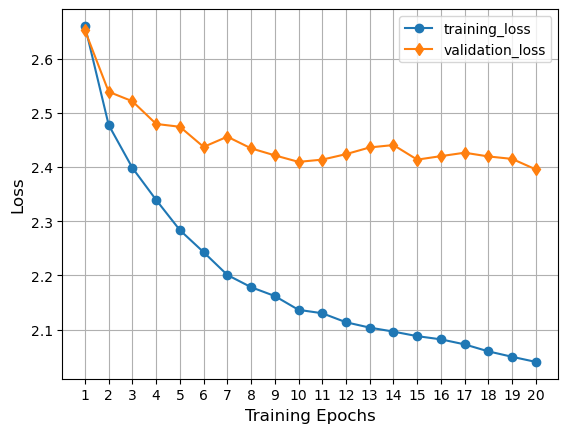

In [5]:
plt.xticks(range(1,21))
plt.plot(scores['train_loss'], marker='o', label='training_loss')
plt.plot(scores['val_loss'], marker='d', label='validation_loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

plot_dir = os.path.join(ROOT_DIR, 'plots\\fma_resnet_learning-curve-loss.png')
plt.savefig(plot_dir)

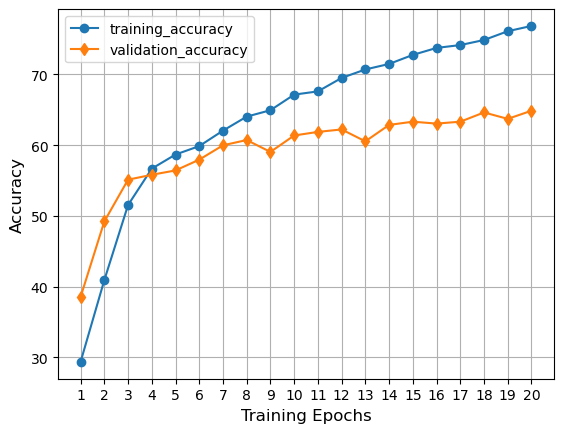

In [7]:
plt.xticks(range(1,21))
plt.plot(scores['train_accuracy'], marker='o', label='training_accuracy')
plt.plot(scores['val_accuracy'], marker='d', label='validation_accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

plot_dir = os.path.join(ROOT_DIR, 'plots\\fma_20e_resnet_learning-curve-accuracy.png')
plt.savefig(plot_dir)

#### Evaluate Best Model Epoch

In [8]:
conv_base = models.resnet152(weights='DEFAULT')
in_features = conv_base.fc.in_features
conv_base.fc = torch.nn.Identity()

test_model = nn.Sequential(
  conv_base,
  nn.Flatten(),
  nn.Linear(in_features, 512),
  nn.Dropout(p=0.3),
  nn.ReLU(),
  nn.Linear(512, NUM_CLASSES),
  nn.Softmax(dim=-1)
)

In [17]:
best_model_path = os.path.join(ROOT_DIR, 'saved_models\\fma_resnet_fine_tuning_epoch_20_64.8678.pt')
test_model.load_state_dict(torch.load(best_model_path))

# unwrap if model saved with DataParallel
if isinstance(test_model, nn.DataParallel):
    test_model = test_model.module

test_model.eval()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [10]:
# load test files
pkl_dir = os.path.join(ROOT_DIR, 'pickle_files\\fma_fine_tuning_resnet152_pytorch_test_files.pkl')
with open(pkl_dir, 'rb') as f:
  test_files = pickle.load(f)

In [11]:
class CustomDataset(Dataset):
    def __init__(self, files, specto_dir, label_dict, IMG_WIDTH, IMG_HEIGHT):
        self.files = files
        self.specto_dir = specto_dir
        self.label_dict = label_dict
        self.one_hot = one_hot
        self.IMG_WIDTH = IMG_WIDTH
        self.IMG_HEIGHT = IMG_HEIGHT

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_ = self.files[idx]
        im = Image.open(self.specto_dir + file_)
        im = im.resize((self.IMG_WIDTH, self.IMG_HEIGHT), Image.Resampling.LANCZOS)
        spectogram = np.array(im) / 255.0
        
        label = file_[:-4].split('_')
        label_array = np.array([self.label_dict[label[1]]])
        label_array = label_array.reshape(1, -1)
        label_array = one_hot.fit_transform(label_array).toarray()

        return spectogram, np.array(label_array[0])
    
# set training optimizer, loss, and metrics
optimizer = optim.Adam(test_model.parameters(), lr=1e-5, weight_decay=L2_LAMBDA)
loss_function = torch.nn.functional.cross_entropy

def categorical_accuracy(output, target):
    predicted = torch.argmax(output, dim=-1)
    labels = torch.argmax(target, dim=-1)
    correct = (predicted == labels).float()
    return correct.sum() 

In [18]:
# Make Prediction on Test set
TEST_STEPS = len(test_files)//BATCH_SIZE

test_dataset = CustomDataset(test_files, SPECTO_DIR, label_dict, IMG_WIDTH, IMG_HEIGHT)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_loss = 0.0
correct_test = 0
total_test = 0

preds = np.empty((0,))
pred_labels = np.empty((0,))
pred_probs = np.empty((0,len(label_dict)))

test_model.to(device)

with torch.no_grad():
  for batch_idx, (inputs, targets) in tqdm(enumerate(test_loader), total=TEST_STEPS):
    # Permute the inputs to [N, C, H, W] from [N, H, W, C]
    inputs = inputs.permute(0, 3, 1, 2)
    inputs = inputs.to(device, dtype=torch.float32)
    targets = targets.to(device, dtype=torch.float32)
    outputs = test_model(inputs)  # Forward pass
    loss = loss_function(outputs, targets)  # Calculate the loss
    test_loss += loss.item()
    total_test += targets.size(0)
    correct_test += categorical_accuracy(outputs, targets)

    # for confusion matrix later
    preds = np.concatenate((preds, torch.argmax(outputs.cpu(), dim=-1).flatten()), axis=0)
    pred_labels = np.concatenate((pred_labels, torch.argmax(targets.cpu(), dim=-1).flatten()), axis=0)
    # for ROC later
    pred_probs = np.concatenate((pred_probs, outputs.cpu()), axis=0)

# Calculate average validation loss and accuracy
avg_test_loss = test_loss / TEST_STEPS
test_accuracy = 100. * correct_test / total_test

# Print test metrics
print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
print('Test Set F-score =  {0:.2f}'.format(f1_score(y_true=pred_labels[:len(preds)], y_pred=preds, average='macro')))


  0%|          | 0/116 [00:00<?, ?it/s]

117it [01:36,  1.21it/s]                         

Test Loss: 2.2590, Test Accuracy: 63.69%
Test Set F-score =  0.52


In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plot_dir = os.path.join(ROOT_DIR, 'plots\\fma_20e_resnet_confusion_matrix.png')
    plt.savefig(plot_dir)
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records], dtype=int)
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

Confusion matrix, without normalization
[[282   1   5  20   0   0   3   0   7   4   0   2   0   1   1   2]
 [ 44 683  48  53   0  15  50  52  28   6   8  23   2  19  17   0]
 [ 16   4  98  13   0   3   4   6   1   4   4   1   1   3   1   2]
 [120  21  22 544   0  11  96  13  64   4  13  22   1   0   3   4]
 [ 30  33  20  24   0   2  16  30   6   2   5  11   1   6   0   0]
 [  1   2   9   3   0  27   4   5  11   0   5   2   0   0   2   0]
 [ 18  20  15  25   0  11 169  15  27  13  16   3   4   3   7   0]
 [  7   8  23   6   0   3   9 152   9   1   7   2   1  11   1   0]
 [  4  21   4  17   0   6  30  11  99   1   9   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0  10   0   0   0   0   1   0]
 [  0   0   0   0   0   1   0   2  11   0  69   0   0   0   0   0]
 [  3   3   2   1   0   1   0   0   0   0   0   9   0   1   0   0]
 [  0   0   0   0   0   1   0   0   0   0   1   0  68   0   0   0]
 [  0   3   6   0   0   0   1   2   0   0   0   0   0  14   0   0]
 [  1   2   0   0   0 

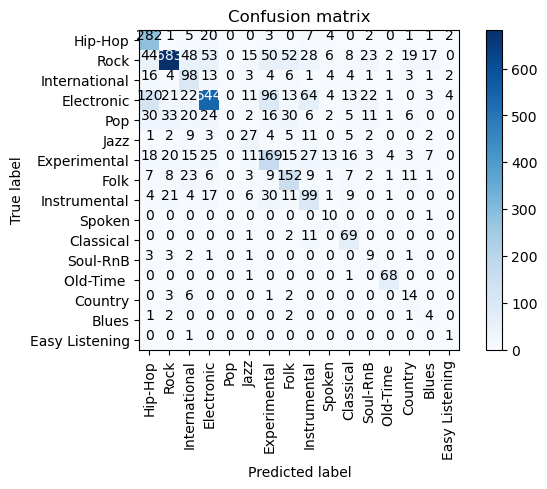

In [14]:
plot_confusion_matrix(confusion_matrix(y_true=pred_labels[:len(preds)], y_pred=preds), 
                      classes=label_dict.keys())

In [15]:
one_hot_true = one_hot_encoder(pred_labels, len(preds), len(label_dict))
print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))

ROC AUC = 0.885


C:\Users\Alex\AppData\Local\Temp\ipykernel_24156\3922992264.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


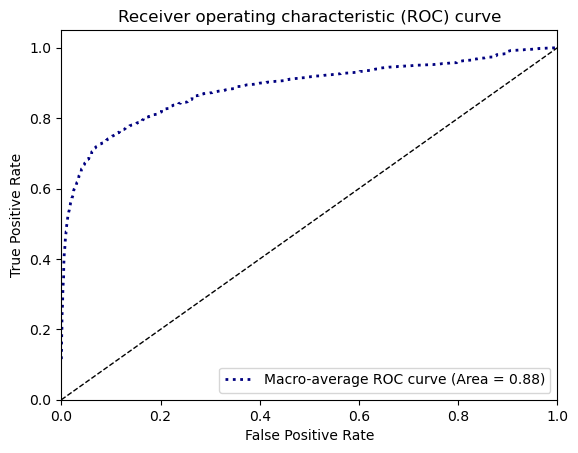

<Figure size 640x480 with 0 Axes>

In [16]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])    

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= NUM_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (Area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

plot_dir = os.path.join(ROOT_DIR, 'plots\\fma_20e_resnet_ROC_curve.png')
plt.savefig(plot_dir)